# Basic time-series classification machine learning workflow using timegpy

## Premise

While `timegpy` can be used for scientific discovery and to reveal differences in temporal patterns between groups, a common problem solved by time-series data is out-of-sample classification. Since a time-average feature returns a scalar statistic, `timegpy` can be used to find features which can effectively individually distinguish between classes on some input time-series data $X$, and then train a classification algorithm using the values on the top $N$ performing features on unseen data. This tutorial steps through a very simple example of this workflow.

## Import packages

In [2]:
import numpy as np
from timegpy.gp import evolve
from timegpy.create import create
from timegpy.plots import plot_hist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Simulate data

For this tutorial, we are aiming to classify Gaussian noise time series from AR(1) process data. We are going to simulate $N=100$ samples from each class, where each sample is $T=100$ time points long. We are going to set an autoregressive coefficient $\phi=0.7$ which is strong, but not that absurdly strong so as to make the exercise pointless.

The reason `timegpy` works well for this example is on $z$-scored data, the feature $\langle X_{t} X_{t+1} \rangle$ (represented as a string in `timegpy` as `"mean(X_t+0 * X_t+1)"`) is the value of the autocorrelation coefficient at lag 1---which, given our simulated data, we know to be the only distinguishing temporal characteristic between the data. Given this, we should expect to see the values on this feature distributed around $0$ for the noise time series and around $\phi=0.7$ for the AR(1) time series. This gives us a nice ground truth validation that the algorithm is working.

*NOTE: It is highly likely that much more complex time-average features (e.g., `"mean((((X_t+0 ^ 5) / X_t+8) / ((tan(X_t+2) * (X_t+5 - X_t+4)) + sin(X_t+7))))"`) achieve good fitness (i.e., performance) in the algorithm. This is the primary reason why using parsimony-adjusted fitness within the algorithm is recommended.*

In [3]:
def generate_ar1_vs_noise(N, T, phi, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # AR(1) samples
    ar1_data = np.zeros((N, T))
    for i in range(N):
        noise = np.random.normal(0, 1, T)
        ar1 = np.zeros(T)
        ar1[0] = noise[0]
        for t in range(1, T):
            ar1[t] = phi * ar1[t - 1] + noise[t]
        ar1_data[i] = ar1

    # Gaussian noise samples
    noise_data = np.random.normal(0, 1, (N, T))

    # Combine
    X = np.vstack([ar1_data, noise_data])

    # Labels
    y = np.array([1] * N + [0] * N)

    return X, y

X, y = generate_ar1_vs_noise(N=100, T=100, phi=0.7, seed=123)

## Run the genetic programming algorithm

Now that we have our data, we can run the core function in `timegpy` which is `evolve`. `evolve` has a very large set of adjustable parameters (see the [documentation](https://timegpy.readthedocs.io/en/latest/Quickstart.html) for all the details), but here we are just going to use mostly the defaults, with the exception of making the maximum feature size a little smaller (i.e., $6$ potential time lag terms as the maximum), the number of generations with no fitness improvement before algorithm termination a little longer, and enabling parallel processing over $5$ processes to speed up computation time. We are also disabling the ability for the algorithm to generate time-average features with unary functions (i.e., $\sin$, $\cos$, $\tan$) since we know they aren't useful here.

In [ ]:
df_all, df_best = evolve(
    X, y,
    max_lag_terms=6,
    n_generation_improve=5,
    unary_set=None,
    use_parsimony=True,
    seed=123,
    n_procs=5
)

## Check that the single best feature is as expected

Before we go any further, we will quickly check that the best individual feature as determined by parsimony-adjusted fitness is $\langle X_{t} X_{t+1} \rangle$. `evolve` returns a data frame of the best feature's information, so we can easily check.

In [8]:
df_best

,generation,individual,expression,program_size,fitness,fitness_parsimony
1617,1,621,mean((X_t+0 * X_t+1)),3,0.936955,0.914233


We can also use this information to quickly plot the class distributions on this feature using a histogram:

<module 'matplotlib.pyplot' from '/Users/trenthenderson/Documents/Git/timegpy/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

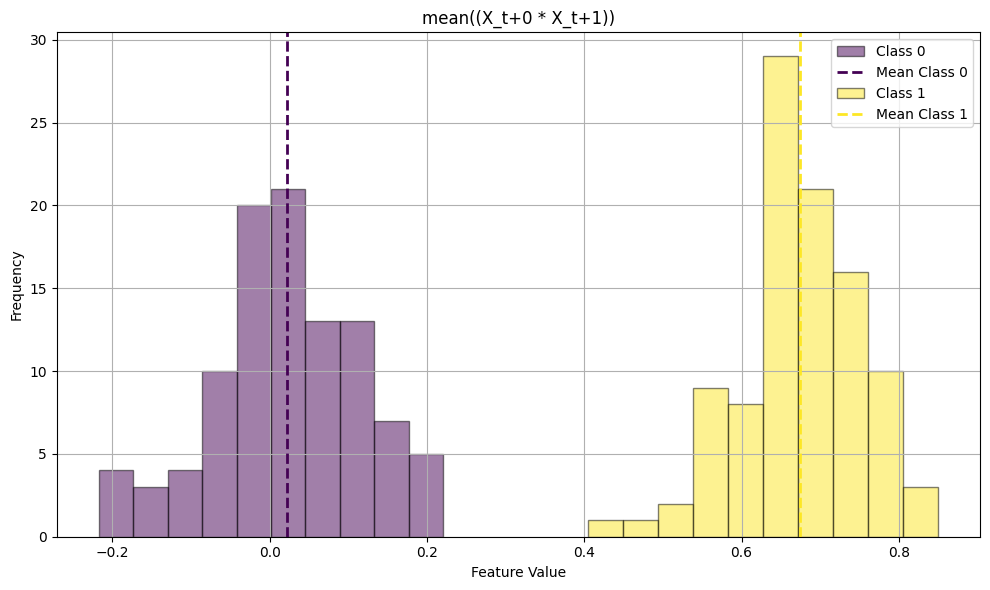

In [9]:
plot_hist(df_best.iloc[0]['expression'], X, y, z_score=True)

## Find the top $10$ unique time-average features to use going forward

For the sake of simplicity in this tutorial, we are going to ignore best practice in selecting features for a machine learning algorithm and just take the top $10$ time-average features to then train a classifier. We can easily do this using `pandas` syntax:

In [10]:
top_expressions = (
    df_all.sort_values(by="fitness_parsimony", ascending=False)
         .drop_duplicates(subset="expression")
         .head(10)
         .expression
         .tolist()
)

print("Top 10 unique expressions:")
for expr in top_expressions:
    print(expr)

Top 10 unique expressions:
mean((X_t+0 * X_t+1))
mean(((X_t+0 * X_t+2) + (((X_t+8 + X_t+3) + X_t+3) * X_t+2)))
mean((((X_t+0 * X_t+1) - ((X_t+6 ^ 3) - (X_t+5 * X_t+4))) - (X_t+6 ^ 2)))
mean(((X_t+0 - (X_t+5 - X_t+2)) + ((X_t+2 * X_t+1) + X_t+6)))
mean((X_t+0 * (((X_t+1 ^ 3) / 0.5815) + (X_t+8 - (X_t+4 * X_t+5)))))
mean(((X_t+0 * ((X_t+1 + -0.3407) + X_t+3)) / (X_t+7 / X_t+7)))
mean((((X_t+0 + X_t+5) * (0.8896 * (0.7769 - X_t+1))) - X_t+4))
mean((((X_t+0 - (X_t+3 - X_t+5)) * X_t+3) - (X_t+7 * 0.7564)))
mean(((X_t+0 - (0.0966 - (X_t+6 * X_t+1))) - (X_t+5 * X_t+6)))
mean(((X_t+0 * X_t+6) + (X_t+3 * ((X_t+6 * X_t+2) + X_t+2))))


## Create training dataset matrix using the time-series data and the top $10$ time-average features

What we need to do now is produce 'training data' that can be used to train the classifier. More specifically, we need a matrix of data where each time series is a row and each time-average feature value is in a column. `timegpy` has a function `create` which takes a collection of time-average feature expressions as strings and the time-series data matrix and produces the time series $\times$ feature matrix:

In [11]:
X_features = create(top_expressions, X, z_score=True)

## Create test set by simulating new data and calculating values on the top $10$ time-average features

Now we'll simulate our test set data. We are going to generate more noise and AR(1) data (but with a weaker autoregressive coefficient of $\phi=0.5$ to make the problem harder) and calculate the feature values for it using `create`.

In [15]:
X2, y2 = generate_ar1_vs_noise(N=100, T=100, phi=0.5, seed=42)
X2_features = create(top_expressions, X2, z_score=True)

## Fit binary classifier

With our train and test data prepared, we can now fit our classification algorithm. For simplicity, we are just going to use logistic regression. We'll first train it on the time-average feature data calculated on `X_features` and then use the model to predict class labels for our unseen data `X2_features`.

In [16]:
clf = LogisticRegression()
clf.fit(X_features, y)
y2_pred = clf.predict(X2_features)

## Calculate classification accuracy

We can finally calculate classification accuracy using the class labels of the unseen data `y2` and our model predictions `y2_pred`.

In [17]:
acc = accuracy_score(y2, y2_pred)
print(f"Test set classification accuracy: {acc:.3f}")

Test set classification accuracy: 0.910
